### CSCI E-82  Homework 5 on CNNs

### Due by 11/13/18 at 11:59pm EST to the Canvas dropbox

## This is an individual homework so there should be no collaboration for this homework.


### Under each problem, we have a place for you to write the answer, or write runnable code that will produce the answer.  Show your work.


This is a busy time of year with homework and an exam coming up.  We are looking for a successful working result that builds upon the section code and enables you to gain some proficiency with this important and growing field of deep learning. 

Depending on your computer, some of the runs may still take a few minutes per epoch.  As a result, Problem 4 may take the better part of a day to run, so plan accordingly.  

## Your Name: 

Paul M. Washburn

ideas
- trump tweets vs. stock and bond markets
- topic extraction on trump tweets

## Dataset

WikiArt is an amazing resource containing centuries of artwork.  Since such datasets are wonderful for deep learning, Kaggle has hosted a challenge to characterize the 'fingerprints' of various artists.  The Kaggle dataset contains metadata and also a set of images that have been resized so that the shorter dimension is 256 pixels.  To make this homework reasonably fast even for those without GPUs, we have further reduced the images to 64 x 64.  CNNs and neural networks in general prefer to have consistent sizes.  To achieve this, we cut the center 256 pixels from the longer dimension and then shrunk the images by a factor of 4. This isn't a perfect solution since it did cut off a few heads as you will see.

The selected images are for portraits and landscapes.  No, we're not talking about the orientation but rather the content of the images. Thanks to help from Rashmi and Dave, we have a small enough data set that should give reasonable results in a timely manner even on just a CPU.

The data were originally divided into a training and a test set.  We have further divided the training set into a train and validation set.  In this homework you will be using the training set and validation set to train and assess your deep learning models.  At the final step, you will see how well your final training worked on the test set.  In each of these directories, there is a truth.txt file that has the image name and whether it is a portrait or landscape scene.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil
from matplotlib import pyplot as plt
from tensorflow import keras
from PIL import Image
import glob
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from time import time

if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

Tensorflow is installed and is version:  1.10.0
Keras is installed and is version:  2.1.6-tf


In [2]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs/{}'.format(time()), **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [5]:
base_dir = 'data/images64'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
train_labels = pd.read_table('data/images64/train/truth.txt', header=None)
val_labels = pd.read_table('data/images64/validation/truth.txt', header=None)

***Do Not Re-run Code Below, Only Run Once***
```python
os.mkdir(os.path.join(train_dir, 'landscape'))
os.mkdir(os.path.join(train_dir, 'portrait'))
os.mkdir(os.path.join(validation_dir, 'landscape'))
os.mkdir(os.path.join(validation_dir, 'portrait'))
```

```python
# move training files
for landscape_pic in train_labels.loc[train_labels[1]=='landscape', 0]:
    current_home = os.path.join(train_dir, landscape_pic)
    new_home = os.path.join(os.path.join(train_dir, 'landscape'), landscape_pic)
    shutil.move(current_home, new_home)
    
for portrait_pic in train_labels.loc[train_labels[1]=='portrait', 0]:
    current_home = os.path.join(train_dir, portrait_pic)
    new_home = os.path.join(os.path.join(train_dir, 'portrait'), portrait_pic)
    shutil.move(current_home, new_home)
    
# move validation files
for landscape_pic in val_labels.loc[val_labels[1]=='landscape', 0]:
    current_home = os.path.join(validation_dir, landscape_pic)
    new_home = os.path.join(os.path.join(validation_dir, 'landscape'), landscape_pic)
    shutil.move(current_home, new_home)
    
for portrait_pic in val_labels.loc[val_labels[1]=='portrait', 0]:
    current_home = os.path.join(validation_dir, portrait_pic)
    new_home = os.path.join(os.path.join(validation_dir, 'portrait'), portrait_pic)
    shutil.move(current_home, new_home)
```

## Problem 1 (5 points)

Read in and display the first 5 portraits and the first 5 landscapes.  Note, if you are using the OpenCV tools, then the color may be distorted.  The cvtColor() method using cv2.COLOR_BGR2RGB may be useful.  However, it is likely easier to use the generator and plot_strip example from section.

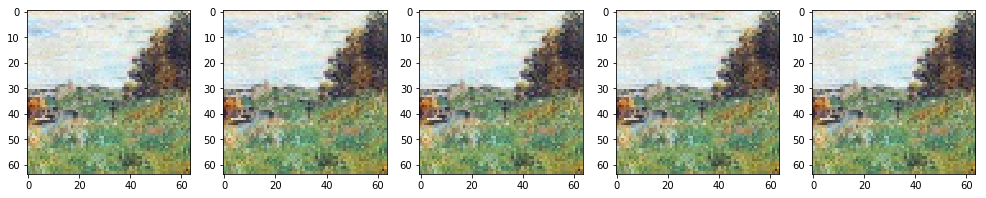

In [9]:
train_files = glob.glob('data/images64/train/landscape/*.jpg')
i = 0
fig, axes = plt.subplots(1, 5, figsize=(17, 5))
for f in train_files:
    while i < 5:
        img = Image.open(f)
        axes[i].imshow(np.asarray(img))
        img.close()
    i += 1
plt.show()

## Problem 2 (25 points)

Construct a baseline CNN classifier using Keras for the training set and assess the validation set performance at each epoch. The goal is to correctly classify portraits from landscapes. Plot the resulting performance on the training and validation set as a function of epoch using the criteria over which you are optimizing.  You should run at least 20 epochs for this problem.

In [14]:
# select batch_size
batch_size = 256

train_datagen = ImageDataGenerator(rescale=1./255,
                                   #featurewise_center=True,
                                   #featurewise_std_normalization=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=batch_size, # somewhat arbitrarily chosen
        class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1./255,
                                #featurewise_center=True,
                                #featurewise_std_normalization=True,
                                rotation_range=20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True)
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64, 64),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

Found 16315 images belonging to 2 classes.
Found 8158 images belonging to 2 classes.


In [17]:
np.random.seed(777)

In [18]:
K.clear_session()

kernel_size = (3,3)
 
early_stopping = EarlyStopping(patience=3)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model = Sequential(name='cnn')

# first convolution
model.add(Conv2D(32, kernel_size, activation='relu',
                 input_shape=(64, 64, 3), 
                 name='conv1',
                 padding='same'))
model.add(AveragePooling2D(kernel_size, name='avg_pool1'))

# second convolution
model.add(Conv2D(64, (5, 5), activation='relu', name = 'conv2', padding='same'))
model.add(Conv2D(32, (5, 5), activation='relu', name = 'conv3', padding='same'))
model.add(AveragePooling2D(kernel_size, name='avg_pool2'))

# model.add(Conv2D(64, (5, 5), activation='relu', name = 'conv4'))
# model.add(Conv2D(32, (5, 5), activation='relu', name = 'conv5'))
# model.add(AveragePooling2D(kernel_size, name='max_pool3'))

model.add(Flatten())
model.add(Dense(1024, activation='relu', name='fc1')) #128
model.add(Dense(1, activation='sigmoid', name='fc2'))

sgd = SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.RMSprop(lr=1e-4),
              #optimizer=sgd,
              optimizer=Adam(lr=1e-4, decay=1e-6),
              metrics=['accuracy'])


# fit model
history = model.fit_generator(train_generator,
                            steps_per_epoch=100,
                            epochs=25,
                            validation_data=validation_generator,
                            validation_steps=50,
                            verbose=1, 
                            callbacks=[tensorboard, early_stopping])

model.summary()

Epoch 1/25
100/100 [==============================] - 165s 2s/step - loss: 0.5147 - acc: 0.7456 - val_loss: 0.4054 - val_acc: 0.8146
Epoch 2/25
100/100 [==============================] - 162s 2s/step - loss: 0.3820 - acc: 0.8307 - val_loss: 0.3444 - val_acc: 0.8524
Epoch 3/25
100/100 [==============================] - 166s 2s/step - loss: 0.3449 - acc: 0.8540 - val_loss: 0.3155 - val_acc: 0.8702
Epoch 4/25
100/100 [==============================] - 166s 2s/step - loss: 0.3257 - acc: 0.8609 - val_loss: 0.2901 - val_acc: 0.8830
Epoch 5/25
100/100 [==============================] - 164s 2s/step - loss: 0.2989 - acc: 0.8796 - val_loss: 0.2790 - val_acc: 0.8945
Epoch 6/25
100/100 [==============================] - 167s 2s/step - loss: 0.2953 - acc: 0.8795 - val_loss: 0.2697 - val_acc: 0.8919
Epoch 7/25
100/100 [==============================] - 164s 2s/step - loss: 0.2827 - acc: 0.8876 - val_loss: 0.2678 - val_acc: 0.8960
Epoch 8/25
100/100 [==============================] - 166s 2s/step - 

In [20]:
model.save_weights('models/attempt_0.h5')

To start tensorboard:

```
Pauls-MacBook-Pro:HW5 pmw$ tensorboard --logdir=logs
```

## Problem 3 (5 points)

From the pattern of training and validation curves, describe what is good/bad and what you plan to do next to improve the result.

## Problem 4 (45 points)

This step is where we want you to do most of your personal learning.  Your goal is to improve the network using a combination of architecture choices, parameter tuning, and experimenting with different optimizers/dropout/regularization/etc. Treat each of these as separate optimization/exploration steps for now.  We would like to see 3 separate steps that cover different areas.  The format of the 3 steps should be as follows:
  * State the hypothesis/strategy for how you will improve/explore a particular aspect.
  * Describe what types of tests you are running and why (i.e. what range of parameters are you choosing and why)
  * Include the code and results
  * State your interpretation of the results
 
We're not looking for research in deep learning, but we want you to gain some hands-on experience working with Keras and figuring out what works. A good example may be comparing strategies to overcome overfitting, or comparing a few different CNN architectures in terms of performance and speed, or comparing data augmentation types and results.  
 


### Hypothesis 1:  Adding another full convolution layer

In [10]:
np.random.seed(777)

K.clear_session()

kernel_size = (3, 3)
 
early_stopping = EarlyStopping(patience=3)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model = Sequential(name='cnn')

# first convolution
model.add(Conv2D(32, kernel_size, activation='relu',
                 input_shape=(64, 64, 3), 
                 name='conv1',
                 padding='same'))
model.add(AveragePooling2D(kernel_size, name='avg_pool1'))

# second convolution
model.add(Conv2D(64, (5, 5), activation='relu', name = 'conv2', padding='same'))
model.add(Conv2D(32, (5, 5), activation='relu', name = 'conv3', padding='same'))
model.add(AveragePooling2D(kernel_size, name='avg_pool2'))

# third - new - convolution
model.add(Conv2D(64, (5, 5), activation='relu', name = 'conv4', padding='same'))
model.add(Conv2D(32, (5, 5), activation='relu', name = 'conv5', padding='same'))
model.add(AveragePooling2D(kernel_size, name='avg_pool3'))

model.add(Flatten())
model.add(Dense(1024, activation='relu', name='fc1'))
model.add(Dense(1, activation='sigmoid', name='fc2'))

sgd = SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.RMSprop(lr=1e-4),
              #optimizer=sgd,
              optimizer=Adam(lr=1e-4, decay=1e-6),
              metrics=['accuracy'])


# fit model
history = model.fit_generator(train_generator,
                            steps_per_epoch=100,
                            epochs=25,
                            validation_data=validation_generator,
                            validation_steps=50,
                            verbose=1, 
                            callbacks=[tensorboard, early_stopping])

model.summary()

Epoch 1/25
100/100 [==============================] - 188s 2s/step - loss: 0.5693 - acc: 0.7221 - val_loss: 0.4646 - val_acc: 0.7817
Epoch 2/25
100/100 [==============================] - 179s 2s/step - loss: 0.4066 - acc: 0.8172 - val_loss: 0.3649 - val_acc: 0.8451
Epoch 3/25
100/100 [==============================] - 171s 2s/step - loss: 0.3770 - acc: 0.8340 - val_loss: 0.3373 - val_acc: 0.8585
Epoch 4/25
100/100 [==============================] - 169s 2s/step - loss: 0.3465 - acc: 0.8545 - val_loss: 0.3176 - val_acc: 0.8725
Epoch 5/25
100/100 [==============================] - 168s 2s/step - loss: 0.3179 - acc: 0.8711 - val_loss: 0.2994 - val_acc: 0.8816
Epoch 6/25
100/100 [==============================] - 172s 2s/step - loss: 0.3141 - acc: 0.8736 - val_loss: 0.3023 - val_acc: 0.8790
Epoch 7/25
100/100 [==============================] - 172s 2s/step - loss: 0.2985 - acc: 0.8796 - val_loss: 0.3089 - val_acc: 0.8697
Epoch 8/25
100/100 [==============================] - 171s 2s/step - 

In [11]:
model.save_weights('models/attempt_1.h5')

### Hypothesis 2:  Using `MaxPooling2D` will improve the accuracy

In [12]:
K.clear_session()

kernel_size = (3, 3)
 
early_stopping = EarlyStopping(patience=3)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model = Sequential(name='cnn')

# first convolution
model.add(Conv2D(32, kernel_size, activation='relu',
                 input_shape=(64, 64, 3), 
                 name='conv1',
                 padding='same'))
model.add(MaxPooling2D(kernel_size, name='max_pool1'))

# second convolution
model.add(Conv2D(64, (5, 5), activation='relu', name = 'conv2', padding='same'))
model.add(Conv2D(32, (5, 5), activation='relu', name = 'conv3', padding='same'))
model.add(MaxPooling2D(kernel_size, name='max_pool2'))

# third - new - convolution
model.add(Conv2D(64, (5, 5), activation='relu', name = 'conv4', padding='same'))
model.add(Conv2D(32, (5, 5), activation='relu', name = 'conv5', padding='same'))
model.add(AveragePooling2D(kernel_size, name='max_pool3'))

model.add(Flatten())
model.add(Dense(1024, activation='relu', name='fc1'))
model.add(Dense(1, activation='sigmoid', name='fc2'))

sgd = SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.RMSprop(lr=1e-4),
              optimizer=Adam(lr=1e-4, decay=1e-6),#sgd,
              metrics=['accuracy'])


# fit model
history = model.fit_generator(train_generator,
                            steps_per_epoch=100,
                            epochs=25,
                            validation_data=validation_generator,
                            validation_steps=50,
                            verbose=1, 
                            callbacks=[tensorboard, early_stopping])

model.summary()

Epoch 1/25
100/100 [==============================] - 171s 2s/step - loss: 0.5248 - acc: 0.7598 - val_loss: 0.3965 - val_acc: 0.8272
Epoch 2/25
100/100 [==============================] - 170s 2s/step - loss: 0.3770 - acc: 0.8372 - val_loss: 0.3397 - val_acc: 0.8555
Epoch 3/25
100/100 [==============================] - 170s 2s/step - loss: 0.3416 - acc: 0.8579 - val_loss: 0.3206 - val_acc: 0.8636
Epoch 4/25
100/100 [==============================] - 171s 2s/step - loss: 0.3199 - acc: 0.8678 - val_loss: 0.2974 - val_acc: 0.8756
Epoch 5/25
100/100 [==============================] - 170s 2s/step - loss: 0.3020 - acc: 0.8777 - val_loss: 0.2985 - val_acc: 0.8837
Epoch 6/25
100/100 [==============================] - 173s 2s/step - loss: 0.2825 - acc: 0.8875 - val_loss: 0.2700 - val_acc: 0.8921
Epoch 7/25
100/100 [==============================] - 167s 2s/step - loss: 0.2671 - acc: 0.8930 - val_loss: 0.2995 - val_acc: 0.8758
Epoch 8/25
100/100 [==============================] - 171s 2s/step - 

In [13]:
model.save_weights('models/attempt_2.h5')

### Hypothesis 3:  Regularizing L1 and L2 will improve the model

In [16]:
from keras import regularizers

K.clear_session()

kernel_size = (7, 7)
pool_size = (2, 2)
 
early_stopping = EarlyStopping(patience=2)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model = Sequential(name='cnn')

# first convolution
model.add(Conv2D(32, kernel_size, activation='relu',
                 input_shape=(64, 64, 3), 
                 name='conv1',
                 padding='same'))
model.add(MaxPooling2D(pool_size, name='max_pool1'))

# second convolution
model.add(Conv2D(64, kernel_size, activation='relu', name = 'conv2', padding='same'))
model.add(Conv2D(32, kernel_size, activation='relu', name = 'conv3', padding='same'))
model.add(MaxPooling2D(pool_size, name='max_pool2'))

# third - new - convolution
model.add(Conv2D(64, kernel_size, activation='relu', name = 'conv4', padding='same'))
model.add(Conv2D(32, kernel_size, activation='relu', name = 'conv5', padding='same'))
model.add(AveragePooling2D(pool_size, name='max_pool3'))

model.add(Flatten())
model.add(Dense(1024, activation='relu', name='fc1'))
model.add(Dense(1, activation='sigmoid', name='fc2'))

sgd = SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='binary_crossentropy',
              #optimizer=RMSprop(lr=1e-4),
              optimizer=Adam(lr=1e-4, decay=1e-6),#sgd,
              metrics=['accuracy'])


# fit model
history = model.fit_generator(train_generator,
                            steps_per_epoch=100,
                            epochs=25,
                            validation_data=validation_generator,
                            validation_steps=50,
                            verbose=1, 
                            callbacks=[tensorboard, early_stopping])

model.summary()

Epoch 1/25
100/100 [==============================] - 636s 6s/step - loss: 0.4800 - acc: 0.7647 - val_loss: 0.3933 - val_acc: 0.8237
Epoch 2/25
100/100 [==============================] - 611s 6s/step - loss: 0.3732 - acc: 0.8342 - val_loss: 0.3409 - val_acc: 0.8530
Epoch 3/25
100/100 [==============================] - 606s 6s/step - loss: 0.3236 - acc: 0.8647 - val_loss: 0.2920 - val_acc: 0.8861
Epoch 4/25
100/100 [==============================] - 608s 6s/step - loss: 0.2955 - acc: 0.8786 - val_loss: 0.2627 - val_acc: 0.8957
Epoch 5/25
100/100 [==============================] - 610s 6s/step - loss: 0.2695 - acc: 0.8918 - val_loss: 0.2705 - val_acc: 0.8895
Epoch 6/25
100/100 [==============================] - 627s 6s/step - loss: 0.2552 - acc: 0.8968 - val_loss: 0.2780 - val_acc: 0.8887
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        4736      
____

In [9]:
model.save_weights('models/attempt_3.h5')

## Problem 5 (10 points)

Assess your best model on the test data.  Plot the corresponding ROC curve from the results (since we've provided the truth).  This was not directly covered in section, but will require a prediction using images in the same format as the training.  We suggest referring to the Keras API else use a Google to search to find how to make predictions.

In [23]:
#model = load_weights('models/attempt_0.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
avg_pool1 (AveragePooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 21, 21, 64)        51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 21, 21, 32)        51232     
_________________________________________________________________
avg_pool2 (AveragePooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              1606656   
__________

In [35]:
test_labels = pd.read_table('data/images64/test/truth.txt', header=None)

```python
# run this only once
os.mkdir(os.path.join(test_dir, 'landscape'))
os.mkdir(os.path.join(test_dir, 'portrait'))

# move test files
for landscape_pic in test_labels.loc[test_labels[1]=='landscape', 0]:
    current_home = os.path.join(test_dir, landscape_pic)
    new_home = os.path.join(os.path.join(test_dir, 'landscape'), landscape_pic)
    shutil.move(current_home, new_home)

for portrait_pic in test_labels.loc[test_labels[1]=='portrait', 0]:
    current_home = os.path.join(test_dir, portrait_pic)
    new_home = os.path.join(os.path.join(test_dir, 'portrait'), portrait_pic)
    shutil.move(current_home, new_home)
```

In [ ]:
batch_size = 256

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size=1, # somewhat arbitrarily chosen
        class_mode='binary')

model.predict_generator(test_generator)

Found 7379 images belonging to 2 classes.


In [ ]:
import scikitplot as skplt

skplt.metrics.plot_roc_curve()

## Problem 6 (5 points)

Display the 5 images [worst] misclassified images for each class.  Worst is in brackets since certain architectures may only make a binary decision rather than a score.  In that case, plot 5 of each.

## Problem 7 (2 points)
How many hours did this homework take you? The answer to this question will not affect your grade.

## Last step (3 points)
Save this notebook as LastnameFirstnameHW5.ipynb such as PriceDavid.ipynb. Create a pdf of this notebook named similarly. Submit both the python notebook and the pdf version to the Canvas dropbox. We require both versions.